# Text Clustering

In [1]:
import pandas as pd

In [48]:
df = pd.read_csv('./text_to_cluster.txt', sep='::', header=None)
df

/home/sourish/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


,0
0,Ransomware attack at Mexico's Pemex halts work...
1,#city | #ransomware | Ransomware Attack At Mex...
2,"Mexico's Pemex Oil Suffers Ransomware Attack, ..."
3,A Mexican oil company was hit by ransomware at...
4,Pemex Struck by Ransomware Attack
...,...
679,Detecting and Responding to Ransomware
680,"Emotet malware is back, more dangerous than ever"
681,Hosting provider SmarterASP.NET hit by ransomw...
682,Ransomware as a Service (RaaS) – A Contemporar...


In [49]:
df.drop_duplicates(keep='first', inplace=True)
df

,0
0,Ransomware attack at Mexico's Pemex halts work...
1,#city | #ransomware | Ransomware Attack At Mex...
2,"Mexico's Pemex Oil Suffers Ransomware Attack, ..."
3,A Mexican oil company was hit by ransomware at...
4,Pemex Struck by Ransomware Attack
...,...
662,Tips for Staying Safe Online
666,Stand up to Cyber Attacks with Cloud Backups
667,"As cloud security improves, a weak link emerge..."
668,Cisco released new patches to fix security bugs


In [51]:
df = df.apply(lambda row: row[0].lower(), axis=1)
df

0      ransomware attack at mexico's pemex halts work...
1      #city | #ransomware | ransomware attack at mex...
2      mexico's pemex oil suffers ransomware attack, ...
3      a mexican oil company was hit by ransomware at...
4                      pemex struck by ransomware attack
                             ...                        
662                         tips for staying safe online
666         stand up to cyber attacks with cloud backups
667    as cloud security improves, a weak link emerge...
668      cisco released new patches to fix security bugs
672    glimpse malware uses alternative dns to evade ...
Length: 331, dtype: object

In [63]:
document = list(df)
document

["ransomware attack at mexico's pemex halts work, threatens to cripple computers",
 '#city | #ransomware | ransomware attack at mexico’s pemex halts work, threatens to cripple computers',
 "mexico's pemex oil suffers ransomware attack, $4.9 million demanded",
 'a mexican oil company was hit by ransomware attack',
 'pemex struck by ransomware attack',
 'mexico’s pemex said it quickly neutralized digital attack',
 'ransomware attack hits mexican state oil firm pemex',
 'ransomware attack at mexican state oil firm halts work, threatens to cripple computers – getaps.site',
 'mexican state oil firm pemex hit by ransomware attack',
 'ransomware attack on the mexican oil giant pemex',
 "ransomware attack at mexico's pemex halts work, threatens to cripple computers by reuters",
 "ransomware attack hits mexico's state oil firm pemex",
 'spain’s largest radio station under siege by bitcoin ransomware attack',
 'ransomware attack hits web hosting provider smarterasp',
 'asp.net hosting provider r

In [74]:
from nltk import WordNetLemmatizer
import nltk
from nltk.corpus import stopwords

# nltk.download("stopwords")

def cleanText(data):
    """
    Clean Text
    - Keep only letters
    - Remove stopwords
    - Stem words
    """
    lemmatizer = WordNetLemmatizer()
    text = re.sub('[^a-zA-Z]', ' ', data)
    words = nltk.word_tokenize(text.lower())
    stops = set(stopwords.words('english'))
    lem_words = [lemmatizer.lemmatize(w) for w in words if w not in stops]
    return ' '.join(lem_words)

In [75]:
X_clean = []
for i in range(len(document)):
    X_clean.append(cleanText(document[i]))
X_clean

['ransomware attack mexico pemex halt work threatens cripple computer',
 'city ransomware ransomware attack mexico pemex halt work threatens cripple computer',
 'mexico pemex oil suffers ransomware attack million demanded',
 'mexican oil company hit ransomware attack',
 'pemex struck ransomware attack',
 'mexico pemex said quickly neutralized digital attack',
 'ransomware attack hit mexican state oil firm pemex',
 'ransomware attack mexican state oil firm halt work threatens cripple computer getaps site',
 'mexican state oil firm pemex hit ransomware attack',
 'ransomware attack mexican oil giant pemex',
 'ransomware attack mexico pemex halt work threatens cripple computer reuters',
 'ransomware attack hit mexico state oil firm pemex',
 'spain largest radio station siege bitcoin ransomware attack',
 'ransomware attack hit web hosting provider smarterasp',
 'asp net hosting provider recovering ransomware attack',
 'hosting provider smarterasp net recovering ransomware attack',
 'smarter

In [78]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(X_clean)

In [79]:
X

<331x904 sparse matrix of type '<class 'numpy.float64'>'
	with 2228 stored elements in Compressed Sparse Row format>

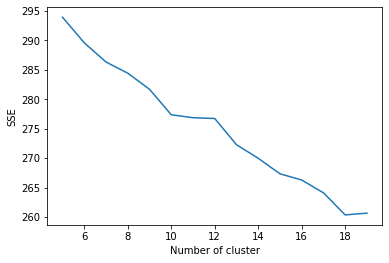

In [89]:
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
%matplotlib inline

sse = {}
for k in range(5, 20):
    kmeans = KMeans(n_clusters=k).fit(X)
    clusters = kmeans.labels_
    #print(data["clusters"])
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

In [90]:
k = 10

kmeans = KMeans(n_clusters=k).fit(X)
clusters = kmeans.labels_
clusters

array([9, 9, 9, 0, 4, 9, 0, 0, 0, 0, 9, 0, 4, 5, 5, 5, 5, 5, 7, 6, 4, 5,
       5, 5, 6, 5, 5, 7, 7, 5, 7, 4, 5, 6, 5, 4, 8, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 3, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 7,
       1, 7, 1, 1, 1, 1, 1, 1, 1, 1, 7, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6,
       6, 6, 1, 1, 7, 8, 8, 8, 8, 8, 2, 2, 2, 2, 2, 2, 7, 7, 7, 7, 4, 7,
       7, 7, 7, 7, 7, 7, 7, 4, 4, 4, 4, 4, 4, 4, 7, 8, 8, 2, 2, 7, 7, 3,
       7, 3, 3, 3, 4, 4, 4, 4, 2, 0, 0, 0, 9, 0, 0, 0, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 3, 4, 4, 8, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 8, 5, 5,
       4, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 4, 4, 8, 4, 4,
       4, 7, 3, 7, 7, 7, 7, 9, 9, 2, 7, 3, 7, 7, 7, 2, 3, 7, 3, 7, 7, 8,
       3, 7, 3, 3, 3, 3, 3, 3, 3, 3, 7, 3, 3, 7, 3, 7, 8, 8, 8, 7, 7, 8,
       7, 7, 7, 8, 8, 8, 7, 4, 7, 7, 7, 3, 8, 4, 8, 7, 7, 8, 7, 7, 1, 1,
       1, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 2, 7, 7, 8, 7, 7, 4, 8, 8,
       4, 8, 7, 8, 8, 8, 4, 8, 8, 8, 7, 7, 8, 8, 7,

In [94]:
df_cluster = pd.DataFrame(list(zip(X_clean, clusters)))
df_cluster

,0,1
0,ransomware attack mexico pemex halt work threa...,9
1,city ransomware ransomware attack mexico pemex...,9
2,mexico pemex oil suffers ransomware attack mil...,9
3,mexican oil company hit ransomware attack,0
4,pemex struck ransomware attack,4
...,...,...
326,tip staying safe online,7
327,stand cyber attack cloud backup,7
328,cloud security improves weak link emerges people,8
329,cisco released new patch fix security bug,8


In [95]:
df_cluster = df_cluster.sort_values(1)

In [96]:
df_cluster

,0,1
141,mexican oil company pemex attacked ransomware,0
11,ransomware attack hit mexico state oil firm pemex,0
147,ransomware attack mexican state oil firm halt ...,0
9,ransomware attack mexican oil giant pemex,0
7,ransomware attack mexican state oil firm halt ...,0
...,...,...
10,ransomware attack mexico pemex halt work threa...,9
5,mexico pemex said quickly neutralized digital ...,9
2,mexico pemex oil suffers ransomware attack mil...,9
1,city ransomware ransomware attack mexico pemex...,9


In [101]:
print(df_cluster[df_cluster[1]==9][0])

144    mexico pemex oil suffers ransomware attack mil...
205       hacker demand million mexico pemex cyberattack
206    ransomware attack mexico pemex halt work threa...
308    mexico pemex oil provider say attempted hack n...
10     ransomware attack mexico pemex halt work threa...
5      mexico pemex said quickly neutralized digital ...
2      mexico pemex oil suffers ransomware attack mil...
1      city ransomware ransomware attack mexico pemex...
0      ransomware attack mexico pemex halt work threa...
Name: 0, dtype: object


In [102]:
print(df_cluster[df_cluster[1]==8][0])

321        security affair newsletter round hackademicus
302               cybersecurity hacker leashing cerberus
285    cyber command flag north korean linked hacker ...
303                    protect company hijacking malware
311                           five pillar cyber security
328     cloud security improves weak link emerges people
287                    check point september top malware
290    apple google enough fight app store malware sa...
291    android smartphone owner fall victim new unrem...
299             check point greece september top malware
293    isro warned dtrack malware chandrayaan mission...
294             ph high malware attack among sea country
295    kaspersky ph rank rd sea android mobile malwar...
304    trickbot malware us fake sexual harassment com...
298                                    leashing cerberus
305    antivirus leverage ai offer security enterpris...
289    google play expelled malware contaminated apps...
301    managed security service

In [103]:
print(df_cluster[df_cluster[1]==7][0])

282       ta cybercrime target system integrator company
248    attack mtproxy server telegram ddos iranian cl...
244    uc browser vulnerability could expose user phi...
243    aussie cybersecurity innovator datasec go glob...
242               optergy remote code execution backdoor
                             ...                        
129    serious x vulnerability found avast desktop an...
104                             cve speculate unexpected
211    vulnerability mcafee antivirus software let ha...
212                 removal instruction full system care
30     breach leading domain name registrar could lea...
Name: 0, Length: 77, dtype: object


In [104]:
print(df_cluster[df_cluster[1]==1][0])

63             cyber attack labour beginning warn expert
70            labour party campaign site hit ddos attack
69     uk labour party targeted large scale cyber attack
68           labour party hit sophisticated cyber attack
66     ddos attack target uk labour party week ahead ...
62                     labour party targeted ddos attack
56           labour party targeted cyber attack politico
60     labour party experience sophisticated large sc...
59              uk labour party say repelled ddos attack
58               labour party confirms cyber attack ddos
57     cybersecurity infosec sophisticated labour cyb...
71          labour party hit cyber attack ahead election
55               labour say hit large scale cyber attack
61     labour party targeted large scale sophisticate...
72        labour party targeted large scale cyber attack
79     hacker mount large scale cyber attack labour p...
74       uk labour party hit cyber attack ahead election
75     uk labour suffers major 